# Time series analysis
### Bots don't get tired.  Or bored.

### How often did these accounts tweet?

In [1]:
import os
import ipywidgets as widgets
import sqlite3 as sql
import datetime
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from pytz import all_timezones

plt.style.use('fivethirtyeight')
#%matplotlib inline

In [2]:
#with sql.connect('../data/eng_tweets.db') as conn:
#    eng_tweets = pd.read_sql_query('select * from eng_tweets', conn)
eng_tweets = pd.read_pickle('../data/eng_tweets.p')
eng_tweets.head()

,external_author_id,author,content,language,publish_date,harvested_date,following,followers,updates,post_type,account_type,retweet,account_category,new_june_2018,alt_external_id,tweet_id,hashtags,mentions
0,906000000000000000,10_GOP,We have a sitting Democrat US Senator on trial...,English,10/1/2017 19:58,10/1/2017 19:59,1052,9636,253,NaN,Right,0,RightTroll,0,905874659358453760,914580356430536707,[],[@nedryun]
1,906000000000000000,10_GOP,Marshawn Lynch arrives to game in anti Trump s...,English,10/1/2017 22:43,10/1/2017 22:43,1054,9637,254,NaN,Right,0,RightTroll,0,905874659358453760,914621840496189440,[],[]
2,906000000000000000,10_GOP,Daughter of fallen Navy Sailor delivers powerf...,English,10/1/2017 22:50,10/1/2017 22:51,1054,9637,255,RETWEET,Right,1,RightTroll,0,905874659358453760,914623490375979008,[#BoycottNFL],[]
3,906000000000000000,10_GOP,JUST IN President Trump dedicates Presidents C...,English,10/1/2017 23:52,10/1/2017 23:52,1062,9642,256,NaN,Right,0,RightTroll,0,905874659358453760,914639143690555392,[],[]
4,906000000000000000,10_GOP,19000 RESPECTING our National Anthem Stand For...,English,10/1/2017 2:13,10/1/2017 2:13,1050,9645,246,RETWEET,Right,1,RightTroll,0,905874659358453760,914312219952861184,[#StandForOurAnthem],[]


In [3]:
eng_tweets['publish_date'] = pd.to_datetime(eng_tweets['publish_date'])

In [4]:
time_series = eng_tweets.groupby(eng_tweets.publish_date.dt.date)['author'].agg('count')
right_trolls = eng_tweets[eng_tweets.account_category=='RightTroll']
right_ts = right_trolls.groupby(right_trolls.publish_date.dt.date)['author'].agg('count')
left_trolls = eng_tweets[eng_tweets.account_category=='LeftTroll']
left_ts = left_trolls.groupby(left_trolls.publish_date.dt.date)['author'].agg('count')
fake_news = eng_tweets[eng_tweets.account_category=='Newsfeed']
news_ts = fake_news.groupby(fake_news.publish_date.dt.date)['author'].agg('count')

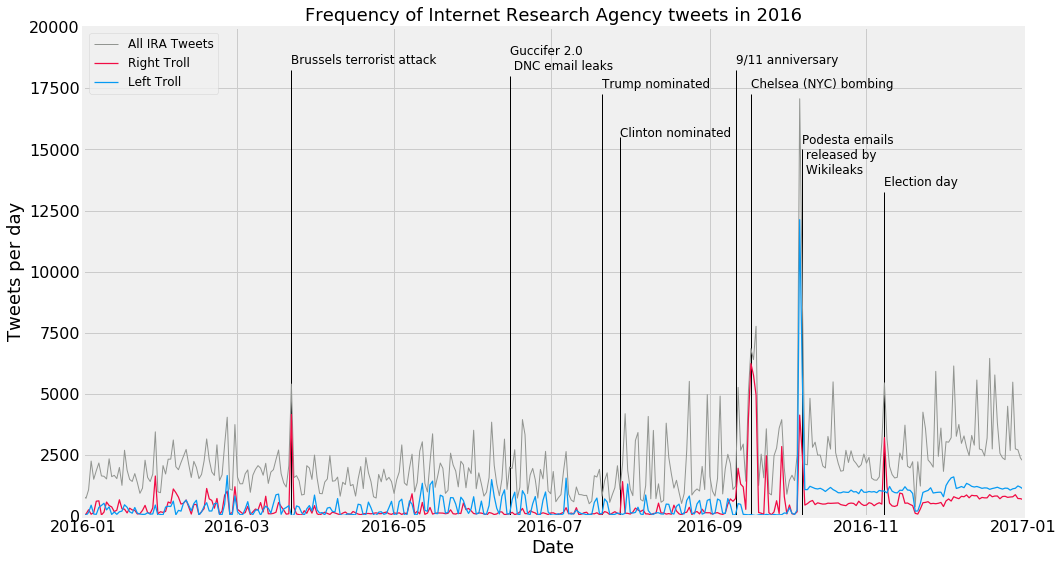

In [23]:
fig, ax = plt.subplots(figsize=(15,9))
ax.xaxis.set_tick_params(labelsize=16)
ax.yaxis.set_tick_params(labelsize=16)

ax.vlines(datetime.date(2016, 3, 22),0,18250, linewidth=1)
ax.text(datetime.date(2016, 3, 22),18500,'Brussels terrorist attack',fontsize=12)

ax.vlines(datetime.date(2016, 11, 8),0,13250, linewidth=1)
ax.text(datetime.date(2016, 11, 8),13500,'Election day',fontsize=12)

ax.vlines(datetime.date(2016, 6, 15),0,18000, linewidth=1)
ax.text(datetime.date(2016, 6, 15),18250,'Guccifer 2.0 \n DNC email leaks',fontsize=12)

ax.vlines(datetime.date(2016, 7, 21),0,17250, linewidth=1)
ax.text(datetime.date(2016, 7, 21),17500,'Trump nominated',fontsize=12)

ax.vlines(datetime.date(2016, 7, 28),0,15500, linewidth=1)
ax.text(datetime.date(2016, 7, 28),15500,'Clinton nominated',fontsize=12)

ax.vlines(datetime.date(2016, 9, 11),0,18250, linewidth=1)
ax.text(datetime.date(2016, 9, 11),18500,'9/11 anniversary',fontsize=12)

ax.vlines(datetime.date(2016, 9, 17),0,17250, linewidth=1)
ax.text(datetime.date(2016, 9, 17),17500,'Chelsea (NYC) bombing',fontsize=12)

ax.vlines(datetime.date(2016, 10, 7),0,15000, linewidth=1)
ax.text(datetime.date(2016, 10, 7),14000,'Podesta emails \n released by \n Wikileaks',fontsize=12)

ax.plot(time_series.index, time_series.values, '-', linewidth=1, color='#929591', label='All IRA Tweets')
ax.plot(right_ts.index, right_ts.values,'-', linewidth=1.25, color='#f10c45',label='Right Troll')
ax.plot(left_ts.index, left_ts.values,'-', linewidth=1.25, color='#069af3', label='Left Troll')
#ax.plot(news_ts.index, news_ts.values, linewidth=1, color='#929591', label='Newsfeed')

ax.set_xlabel('Date', fontsize=18)
ax.set_ylabel('Tweets per day', fontsize=18)
ax.set_xlim(datetime.date(2016, 1, 1), datetime.date(2017, 1, 1))
ax.set_ylim(0,20000)
ax.set_title('Frequency of Internet Research Agency tweets in 2016', fontsize=18)
ax.legend(loc=2, fontsize=12);

In [180]:
eng_tweets.publish_date.head()

0   2017-10-01 19:58:00
1   2017-10-01 22:43:00
2   2017-10-01 22:50:00
3   2017-10-01 23:52:00
4   2017-10-01 02:13:00
Name: publish_date, dtype: datetime64[ns]

In [181]:
#eng_tweets.publish_date = eng_tweets.publish_date.dt.tz_localize('UTC') 
#eng_tweets.publish_date = eng_tweets.publish_date.dt.tz_convert('Europe/Moscow')
eng_tweets['dayofweek'] = eng_tweets.publish_date.dt.day_name()
eng_tweets['timeofday'] = eng_tweets.publish_date
eng_tweets['date'] = eng_tweets.publish_date.dt.date
eng_tweets.publish_date.head()

0   2017-10-01 19:58:00
1   2017-10-01 22:43:00
2   2017-10-01 22:50:00
3   2017-10-01 23:52:00
4   2017-10-01 02:13:00
Name: publish_date, dtype: datetime64[ns]

In [182]:
eng_tweets['dayofweek'].head()

0    Sunday
1    Sunday
2    Sunday
3    Sunday
4    Sunday
Name: dayofweek, dtype: object

In [183]:
eng_tweets.author.value_counts()[0:10]

EXQUOTE            53158
SCREAMYMONKEY      43956
AMELIEBALDWIN      34308
SPECIALAFFAIR      32416
SEATTLE_POST       30680
KANSASDAILYNEWS    28746
ROOMOFRUMOR        28259
DAILYSANFRAN       27962
FINDDIET           25941
COVFEFENATIONUS    23463
Name: author, dtype: int64

In [232]:
eng_tweets[eng_tweets.author=='TEN_GOP'].date.value_counts()

2016-10-10    90
2017-05-23    73
2017-01-20    73
2016-09-27    71
2016-09-08    70
2017-08-23    67
2016-07-22    64
2017-06-03    64
2016-10-20    63
2016-02-07    63
2017-05-22    62
2017-03-15    55
2017-03-01    55
2016-09-24    54
2016-08-07    53
2016-12-19    52
2017-06-23    51
2016-09-17    51
2017-04-20    50
2016-09-16    50
2017-05-10    48
2016-09-20    48
2016-09-01    47
2016-09-04    47
2016-03-29    47
2016-11-08    47
2017-04-30    47
2017-03-03    45
2016-11-02    45
2017-06-28    45
              ..
2016-05-04     3
2017-04-27     3
2016-04-15     2
2016-08-29     2
2016-02-22     2
2016-11-12     2
2017-01-23     2
2015-12-30     2
2016-11-18     2
2017-04-10     2
2015-12-15     2
2016-04-10     2
2016-04-12     2
2016-04-19     2
2016-02-15     2
2017-01-04     2
2016-02-28     1
2016-02-26     1
2016-05-05     1
2017-05-05     1
2015-12-19     1
2016-03-10     1
2016-03-20     1
2016-11-11     1
2016-01-12     1
2016-02-25     1
2016-05-25     1
2016-05-17    

In [185]:
#look at activity of a single account in the month of October--tweets per hour
user_name = 'TEN_GOP'
user = eng_tweets.loc[eng_tweets.author == user_name]
user = user[['author','publish_date','dayofweek','timeofday','date']]
startdate = datetime.datetime.strptime('2016-10-01', "%Y-%m-%d").date()
enddate = datetime.datetime.strptime('2016-10-31', "%Y-%m-%d").date()
mask = (user['date'] >= startdate) & (user['date'] <= enddate)
user = user.loc[mask]
user = user.set_index('publish_date')
user = (user.groupby(by=[user.index.day.rename('day'), 
                             user.index.hour.rename('hour')], as_index=False)
                            ['date','dayofweek','timeofday'].agg(list))
user.date = user.date.apply(lambda x: x[0])
user.dayofweek = user.dayofweek.apply(lambda x: x[0])
user['Tweets per hour'] = user.timeofday.apply(lambda x: len(x))
user.timeofday = user.timeofday.apply(lambda x: x[0])
user.timeofday = user.timeofday.dt.floor('1H').dt.hour
user.timeofday = user.timeofday.astype(str).apply(lambda x: x+":00:00")

### How often did these accounts tweet?

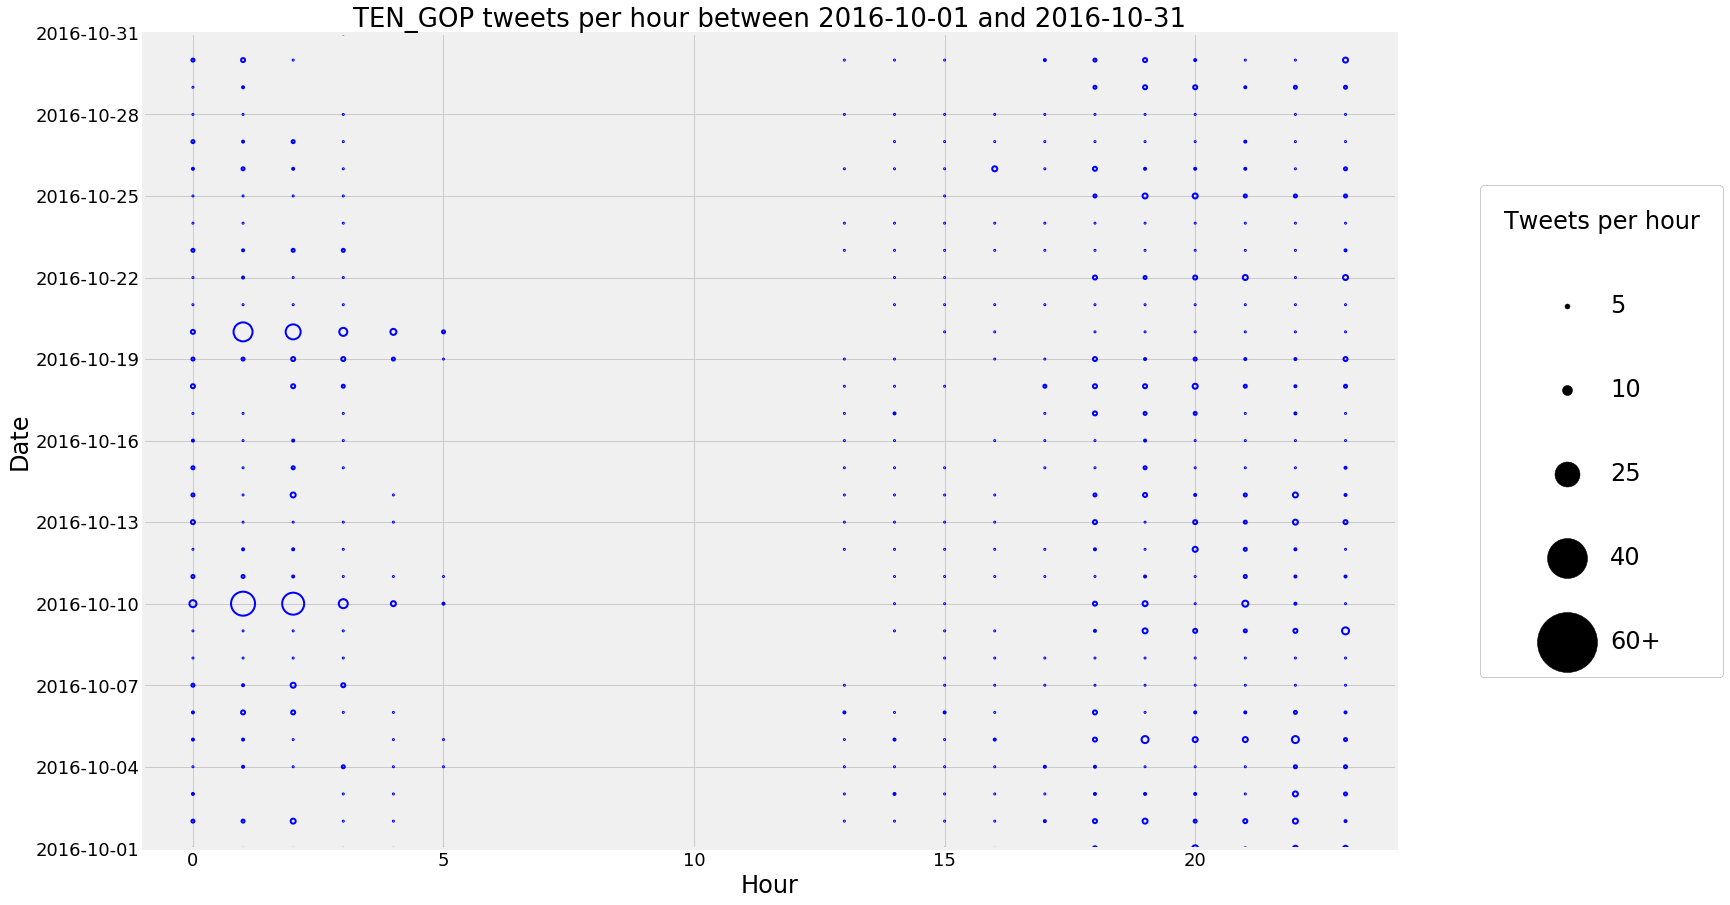

In [186]:
nums = [2, 5, 10, 25, 40, 60]

fig, ax = plt.subplots(figsize=(20,15))
y = [datetime.datetime.strptime(str(date),"%Y-%m-%d") for date in user.date]
x = [datetime.datetime.strptime(str(time),"%H:%M:%S").hour for time in user.timeofday]
sizes = user['Tweets per hour'].astype(float)**2
sizes = [size if size <= float(nums[-1])**2 else float(nums[-1])**2 for size in sizes]
ax.scatter(x, y, s=sizes, edgecolor='b',facecolor='None', linewidths=2)
ax.set_xlim(-1,24)
ax.set_ylim(startdate, enddate)

ax = plt.gca()
plt.xlabel('Hour', fontsize=24)
plt.ylabel('Date', fontsize=24)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)


plt.title(user_name+' tweets per hour between '+str(startdate)+' and '+str(enddate), fontsize=26)


for num in nums:
    label = str(num)
    if num==nums[-1]: label += '+'
    plt.scatter([], [], s=(num**2), edgecolor="k",facecolor='k',label=label)

h, l = plt.gca().get_legend_handles_labels()
plt.legend(h[1:], l[1:], labelspacing=2.5, title="Tweets per hour", fontsize=24, borderpad=1, 
            frameon=True, framealpha=0.4, edgecolor="k", facecolor="w", bbox_to_anchor=(1, 0.75),
           bbox_transform=plt.gcf().transFigure)
ax.get_legend().get_title().set_fontsize('24')

### How often did these accounts tweet?

In [233]:
#look at activity of a single account in the month of October--tweets per hour
def plot_func(user_name):
    user = eng_tweets.loc[eng_tweets.author == user_name]
    user = user[['author','publish_date','dayofweek','timeofday','date']]
    startdate = datetime.datetime.strptime('2015-08-01', "%Y-%m-%d").date()
    enddate = datetime.datetime.strptime('2015-08-31', "%Y-%m-%d").date()
    mask = (user['date'] >= startdate) & (user['date'] <= enddate)
    user = user.loc[mask]
    user = user.set_index('publish_date')
    user = (user.groupby(by=[user.index.day.rename('day'), 
                             user.index.hour.rename('hour')], as_index=False)
                            ['date','dayofweek','timeofday'].agg(list))
    user.date = user.date.apply(lambda x: x[0])
    user.dayofweek = user.dayofweek.apply(lambda x: x[0])
    user['Tweets per hour'] = user.timeofday.apply(lambda x: len(x))
    user.timeofday = user.timeofday.apply(lambda x: x[0])
    user.timeofday = user.timeofday.dt.floor('1H').dt.hour
    user.timeofday = user.timeofday.astype(str).apply(lambda x: x+":00:00")

    nums = [2, 5, 10, 25, 40, 60]

    fig, ax = plt.subplots(figsize=(20,15))
    y = [datetime.datetime.strptime(str(date),"%Y-%m-%d") for date in user.date]
    x = [datetime.datetime.strptime(str(time),"%H:%M:%S").hour for time in user.timeofday]
    sizes = user['Tweets per hour'].astype(float)**2
    sizes = [size if size <= float(nums[-1])**2 else float(nums[-1])**2 for size in sizes]
    ax.scatter(x, y, s=sizes, edgecolor='b',facecolor='None', linewidths=2)
    ax.set_xlim(-1,24)
    ax.set_ylim(startdate, enddate)

    ax = plt.gca()
    plt.xlabel('Hour', fontsize=24)
    plt.ylabel('Date', fontsize=24)
    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18)
    plt.title(user_name+' tweets per hour between '+str(startdate)+' and '+str(enddate), fontsize=26)

    for num in nums:
        label = str(num)
        if num==nums[-1]: label += '+'
        plt.scatter([], [], s=(num**2), edgecolor="k",facecolor='k',label=label)

    h, l = plt.gca().get_legend_handles_labels()
    plt.legend(h[1:], l[1:], labelspacing=2.5, title="Tweets per hour", fontsize=24, borderpad=1, 
            frameon=True, framealpha=0.4, edgecolor="k", facecolor="w", bbox_to_anchor=(1, 0.75),
           bbox_transform=plt.gcf().transFigure)
    ax.get_legend().get_title().set_fontsize('24');
    
widgets.interact(plot_func, user_name=widgets.Dropdown(
    options=eng_tweets.author,
    value='TEN_GOP',
    description='User:',
    disabled=False));

interactive(children=(Dropdown(description='User:', index=1810363, options=('10_GOP', '10_GOP', '10_GOP', '10_…

### How often did these accounts tweet?

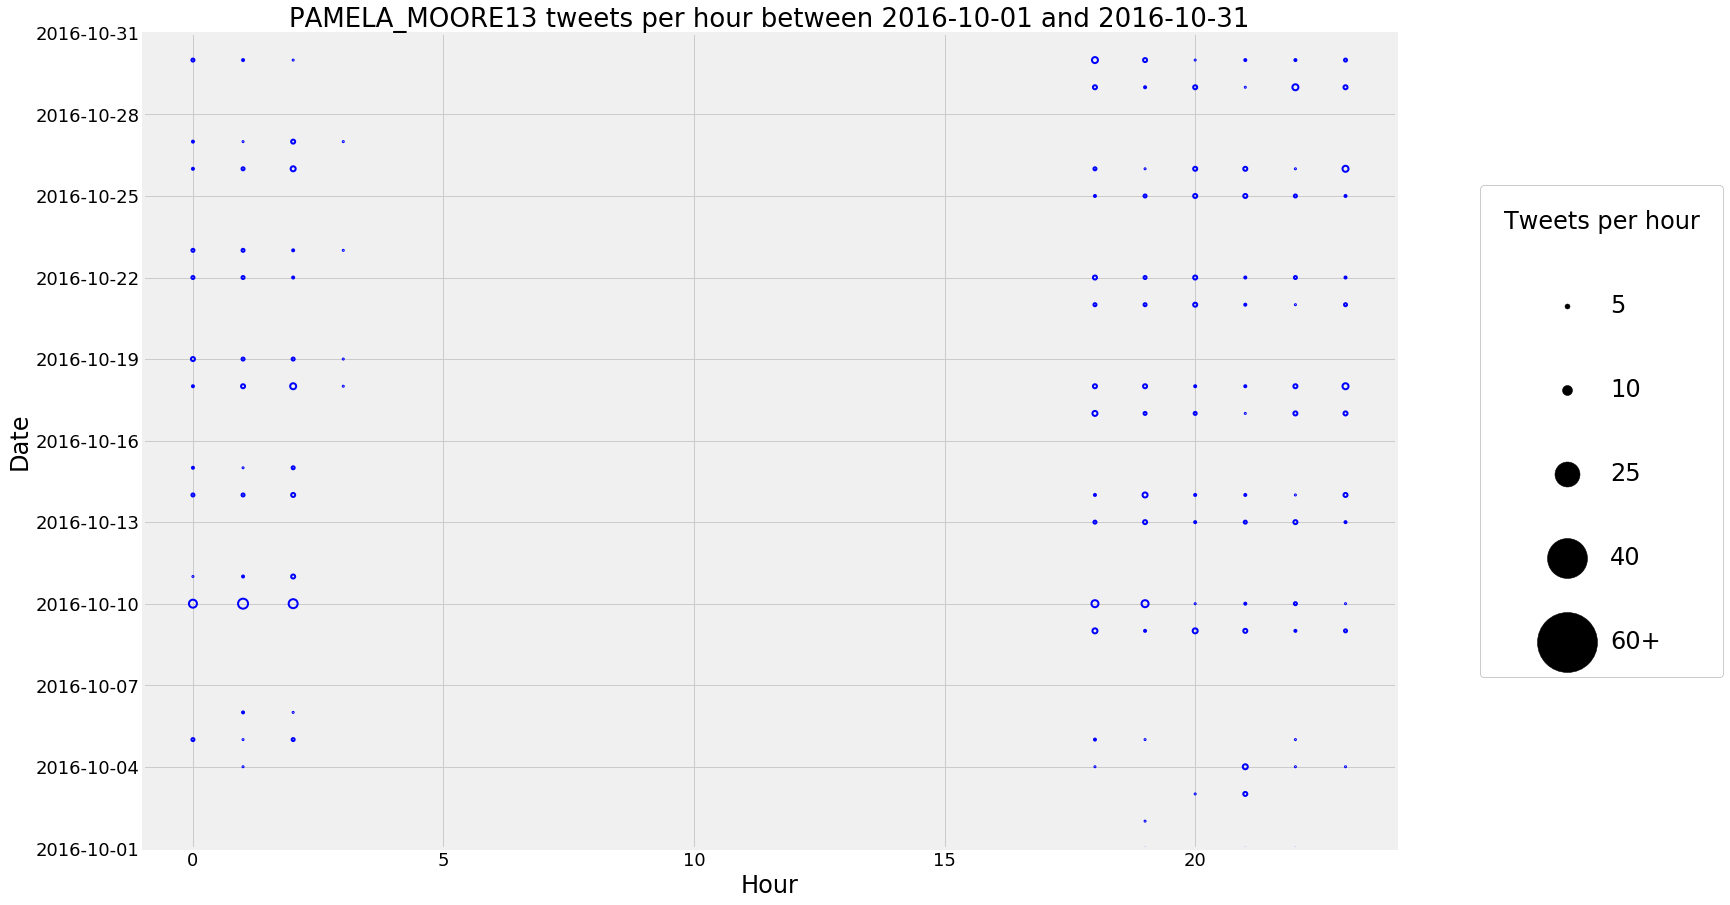

In [188]:
#look at activity of a single account in the month of October--tweets per hour
user_name = 'PAMELA_MOORE13'
user = eng_tweets.loc[eng_tweets.author == user_name]
user = user[['author','publish_date','dayofweek','timeofday','date']]
startdate = datetime.datetime.strptime('2016-10-01', "%Y-%m-%d").date()
enddate = datetime.datetime.strptime('2016-10-31', "%Y-%m-%d").date()
mask = (user['date'] >= startdate) & (user['date'] <= enddate)
user = user.loc[mask]
user = user.set_index('publish_date')
user = (user.groupby(by=[user.index.day.rename('day'), 
                             user.index.hour.rename('hour')], as_index=False)
                            ['date','dayofweek','timeofday'].agg(list))
user.date = user.date.apply(lambda x: x[0])
user.dayofweek = user.dayofweek.apply(lambda x: x[0])
user['Tweets per hour'] = user.timeofday.apply(lambda x: len(x))
user.timeofday = user.timeofday.apply(lambda x: x[0])
user.timeofday = user.timeofday.dt.floor('1H').dt.hour
user.timeofday = user.timeofday.astype(str).apply(lambda x: x+":00:00")

nums = [2, 5, 10, 25, 40, 60]

fig, ax = plt.subplots(figsize=(20,15))
y = [datetime.datetime.strptime(str(date),"%Y-%m-%d") for date in user.date]
x = [datetime.datetime.strptime(str(time),"%H:%M:%S").hour for time in user.timeofday]
sizes = user['Tweets per hour'].astype(float)**2
sizes = [size if size <= float(nums[-1])**2 else float(nums[-1])**2 for size in sizes]
ax.scatter(x, y, s=sizes, edgecolor='b',facecolor='None', linewidths=2)
ax.set_xlim(-1,24)
ax.set_ylim(startdate, enddate)

ax = plt.gca()
plt.xlabel('Hour', fontsize=24)
plt.ylabel('Date', fontsize=24)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)


plt.title(user_name+' tweets per hour between '+str(startdate)+' and '+str(enddate), fontsize=26)


for num in nums:
    label = str(num)
    if num==nums[-1]: label += '+'
    plt.scatter([], [], s=(num**2), edgecolor="k",facecolor='k',label=label)

h, l = plt.gca().get_legend_handles_labels()
plt.legend(h[1:], l[1:], labelspacing=2.5, title="Tweets per hour", fontsize=24, borderpad=1, 
            frameon=True, framealpha=0.4, edgecolor="k", facecolor="w", bbox_to_anchor=(1, 0.75),
           bbox_transform=plt.gcf().transFigure)
ax.get_legend().get_title().set_fontsize('24')

### How often did these accounts tweet?

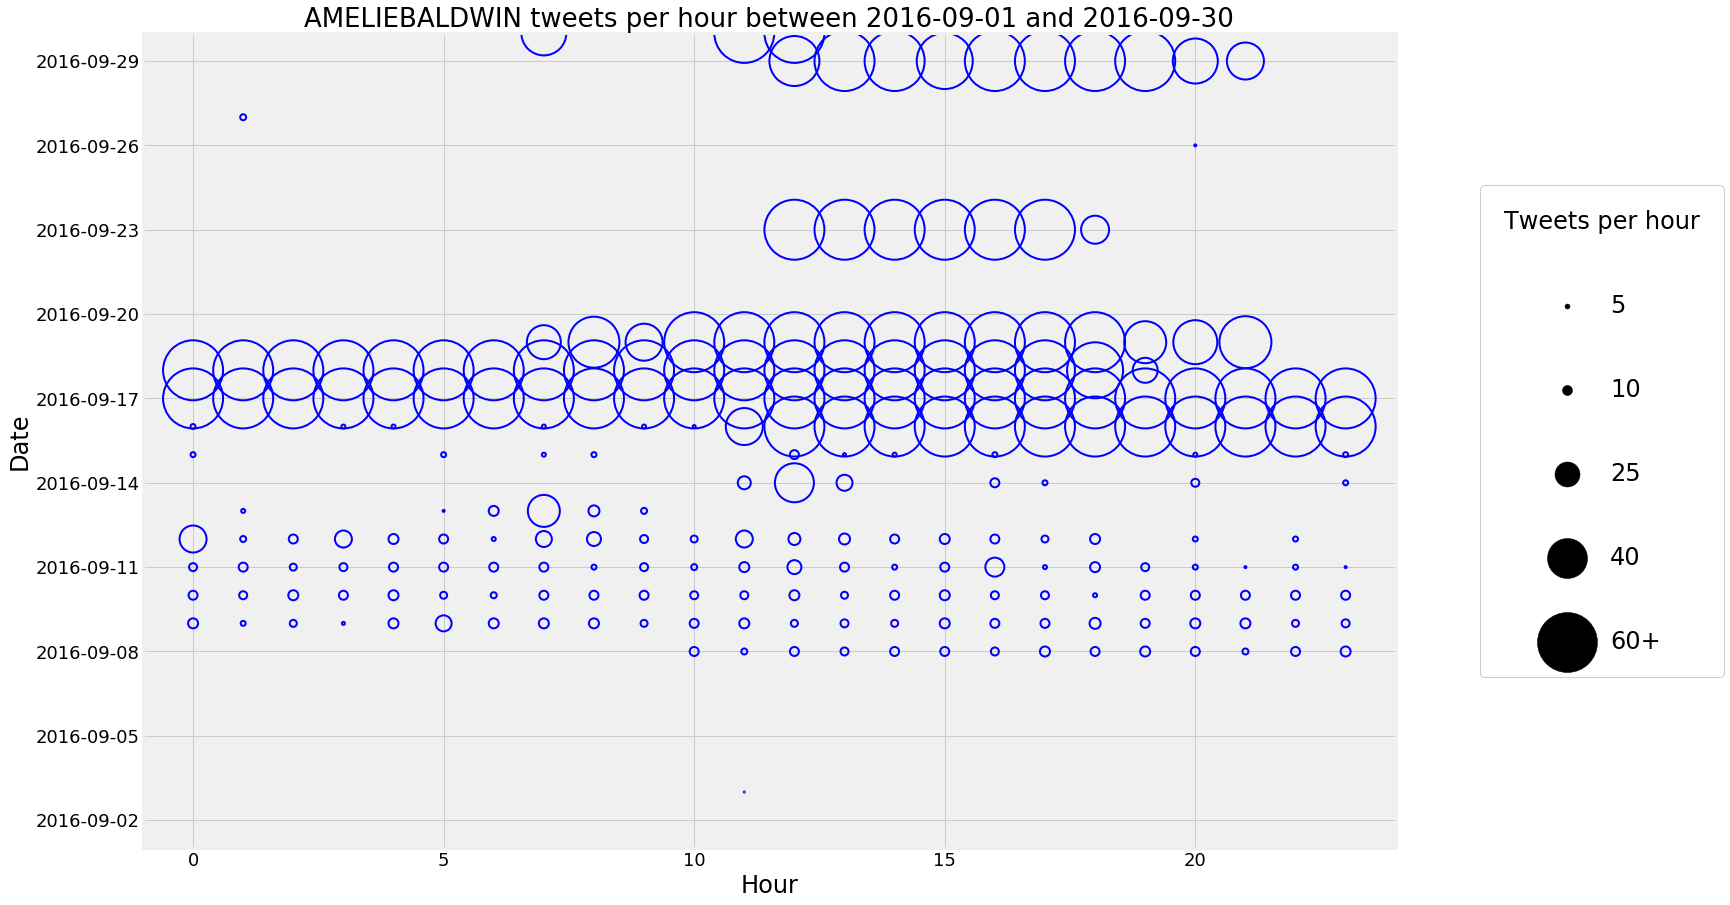

In [189]:
#look at activity of a single account over a month--tweets per hour
user_name = 'AMELIEBALDWIN'
user = eng_tweets.loc[eng_tweets.author == user_name]
user = user[['author','publish_date','dayofweek','timeofday','date']]
startdate = datetime.datetime.strptime('2016-09-01', "%Y-%m-%d").date()
enddate = datetime.datetime.strptime('2016-09-30', "%Y-%m-%d").date()
mask = (user['date'] >= startdate) & (user['date'] <= enddate)
user = user.loc[mask]
user = user.set_index('publish_date')
user = (user.groupby(by=[user.index.day.rename('day'), 
                             user.index.hour.rename('hour')], as_index=False)
                            ['date','dayofweek','timeofday'].agg(list))
user.date = user.date.apply(lambda x: x[0])
user.dayofweek = user.dayofweek.apply(lambda x: x[0])
user['Tweets per hour'] = user.timeofday.apply(lambda x: len(x))
user.timeofday = user.timeofday.apply(lambda x: x[0])
user.timeofday = user.timeofday.dt.floor('1H').dt.hour
user.timeofday = user.timeofday.astype(str).apply(lambda x: x+":00:00")

nums = [2, 5, 10, 25, 40, 60]

fig, ax = plt.subplots(figsize=(20,15))
y = [datetime.datetime.strptime(str(date),"%Y-%m-%d") for date in user.date]
x = [datetime.datetime.strptime(str(time),"%H:%M:%S").hour for time in user.timeofday]
sizes = user['Tweets per hour'].astype(float)**2
sizes = [size if size <= float(nums[-1])**2 else float(nums[-1])**2 for size in sizes]
ax.scatter(x, y, s=sizes, edgecolor='b',facecolor='None', linewidths=2)
ax.set_xlim(-1,24)
ax.set_ylim(startdate, enddate)

ax = plt.gca()
plt.xlabel('Hour', fontsize=24)
plt.ylabel('Date', fontsize=24)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)


plt.title(user_name+' tweets per hour between '+str(startdate)+' and '+str(enddate), fontsize=26)


for num in nums:
    label = str(num)
    if num==nums[-1]: label += '+'
    plt.scatter([], [], s=(num**2), edgecolor="k",facecolor='k',label=label)

h, l = plt.gca().get_legend_handles_labels()
plt.legend(h[1:], l[1:], labelspacing=2.5, title="Tweets per hour", fontsize=24, borderpad=1, 
            frameon=True, framealpha=0.4, edgecolor="k", facecolor="w", bbox_to_anchor=(1, 0.75),
           bbox_transform=plt.gcf().transFigure)
ax.get_legend().get_title().set_fontsize('24')